# nuSQuIDS decoherence example

This notebook demonstrates how to calculate oscillation probabilities for neutrinos in the presence of decoherence effects.

We use mathematical formalism defined in https://arxiv.org/abs/0805.2098.

Oscillation probabilities are calculated in 1D, w.r.t. energy and baseline. The energies and baselines shown are chosen to be relevent for atmospheric neutrinos.

Contact Tom Stuttard (stuttard@nbi.ku.dk) with questions/issues.

In [6]:
import collections, datetime

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import nuSQUIDSpy as nsq

## Configuring nuSQuIDS

In [7]:
# Units container
units = nsq.Const()

# Define neutrino flavors/states
flavs = [0,1,2]
flavs_tex = [r"\nu_e",r"\nu_{\mu}",r"\nu_{\tau}"]

# Define energy nodes
energy_nodes = np.linspace(0.,100.,num=10) * units.GeV

# Instantiate nuSQuIDS
# Using multi-energy mode, and only neutrinos (no antineutrinos)
nusquids = nsq.nuSQUIDSDecoh(energy_nodes,len(flavs),nsq.NeutrinoType.neutrino)

# Don't want debug printing
nusquids.Set_Debug(False)

# Set tolerance for numerical solving the oscillation probabilities
error = 1.e-4
nusquids.Set_rel_error(error)
nusquids.Set_abs_error(error)

# Not considering matter here, e.g. just assuming vacuum oscillations/decoherence
nusquids.Set_Body(nsq.Vacuum())

## Choose decoherence parameters

In [8]:
# Defining the decoherence using 3 damping parameters [eV]
gamma21 = 1.e-14
gamma31 = 1.e-14
gamma32 = 1.e-14
nusquids.Set_DecoherenceGammaMatrix(gamma21,gamma31,gamma32)

# Show the resulting 3x3 matrix
print "Decoherence Gamma matrix:"
print nusquids.Get_DecoherenceGammaMatrix()

# Define energy dependence
energy_index = 0
nusquids.Set_DecoherenceGammaEnergyDependence(energy_index)

# Show the internal value as a check
print "\nDecoherence Gamma energy dependence:"
print nusquids.Get_DecoherenceGammaEnergyDependence() 

Decoherence Gamma matrix:
[[0.e+00 1.e-14 1.e-14]
 [1.e-14 0.e+00 1.e-14]
 [1.e-14 1.e-14 0.e+00]]

Decoherence Gamma energy dependence:
0.0


## Oscillation probability versus distance

Ran solver (standard oscillations), took 0:00:00.046394
Ran solver (decoherence), took 0:00:00.159601


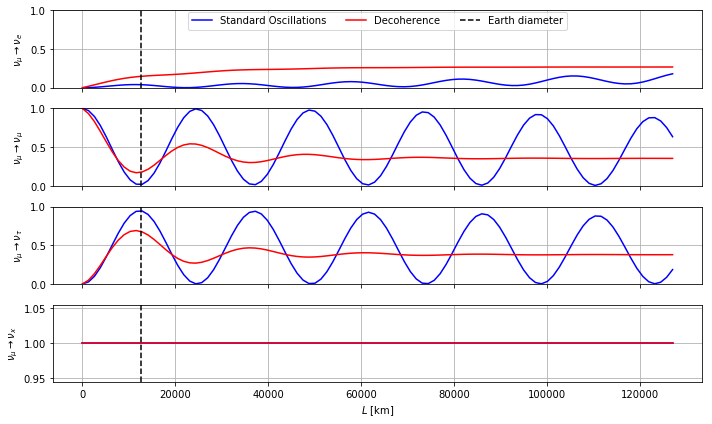

In [9]:
# Define a range of distances covering a few Earth diameters
earth_diameter = 12.7e3
baseline_values = np.linspace(0.,earth_diameter*10.,num=100)

# Choose a neutrino energy
neutrino_energy = 25.0*units.GeV

# Initial state
# Here starting as 100% muon neutrino
ini_flav = 1
ini_state = np.zeros((energy_nodes.size,len(flavs),))
ini_state[:,ini_flav] = 1.

# A plot to fill
fig,ax = plt.subplots(len(flavs)+1,1,sharex=True,figsize=(10,6))

# Calculate for standard oscillations and for decoherence cases
for enable_decoherence,color in zip([False,True],["blue","red"]) :

    start_time = datetime.datetime.now()
    
    # Enable/disable decoherence effects
    nusquids.EnableDecoherence(enable_decoherence)
    physics_model = "decoherence" if enable_decoherence else "standard oscillations"

    # Container to store results
    osc_probs = np.full( (baseline_values.size,len(flavs)), np.NaN )

    # Loop over baselines
    # nuSQuIDS allows you to calculate for a range of energies but not a range of distances
    # Therefore have to perform calculation for every distance value
    for i_L,L in enumerate(baseline_values) :

        # Define a track that represents the propagation of the particle
        nusquids.Set_Track(nsq.Vacuum.Track(L*units.km))
        
        # Define the track
        nusquids.Set_initial_state(ini_state,nsq.Basis.flavor)

        # Evolve the intitial state to the requested baseline
        nusquids.EvolveState()

        # Solve to get the probability for each flavor
        for i_f,flav in enumerate(flavs) :
            osc_probs[i_L,i_f] = nusquids.EvalFlavor(flav,neutrino_energy,0)

    # Compute the total probability to be in one if the states
    # Should be 1 unless have chosen gamma values that violate unitarity
    total_prob = np.sum(osc_probs,axis=1)

    end_time = datetime.datetime.now()

    print "Ran solver (%s), took %s" % (physics_model,end_time-start_time)

    # Plot the calculated oscillation probability
    ini_flav_tex = flavs_tex[ini_flav]
    for i,(flav,tex) in enumerate(zip(flavs,flavs_tex)) :
        ax[i].plot( baseline_values, osc_probs[:,i], color=color, label=physics_model.title() )
        ax[i].set_ylabel(r"$%s \rightarrow %s$" % (ini_flav_tex,tex))
        ax[i].grid(True)
        ax[i].set_ylim(0.,1.)
    
    # Plot the total probability to oscillate into something
    ax[-1].plot( baseline_values, total_prob, color=color, label=physics_model.title() )
    ax[-1].set_ylabel(r"$%s \rightarrow \nu_{x}$" % (ini_flav_tex))
    ax[-1].grid(True)

for a in ax :
    a.grid(True)
    a.axvline( x=earth_diameter, label="Earth diameter", color="black", linestyle="--" )
ax[-1].set_xlabel(r"$L$ [km]")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5,1.05), ncol=3);
fig.tight_layout()

## Oscillation probability versus energy

Ran solver (standard oscillations), took 0:00:00.000790
Ran solver (decoherence), took 0:00:00.001969


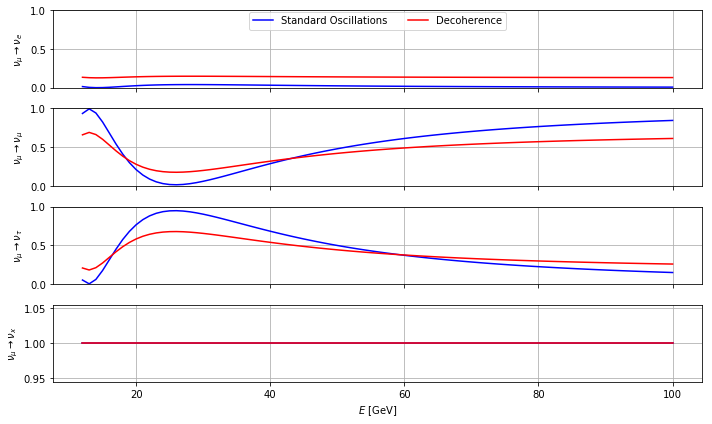

In [10]:
# Define a range of energies
energy_values = np.linspace(1.,100.,num=100)

# Choose a distance
# Here choosing the Earth's diameter
baseline = earth_diameter

# Initial state
# Here starting as 100% muon neutrino
ini_flav = 1
ini_state = np.zeros((energy_nodes.size,len(flavs),))
ini_state[:,ini_flav] = 1.

# A plot to fill
fig,ax = plt.subplots(len(flavs)+1,1,sharex=True,figsize=(10,6))

# Calculate for standard oscillations and for decoherence cases
for enable_decoherence,color in zip([False,True],["blue","red"]) :

    start_time = datetime.datetime.now()
    
    # Enable/disable decoherence effects
    nusquids.EnableDecoherence(enable_decoherence)
    physics_model = "decoherence" if enable_decoherence else "standard oscillations"

    # Container to store results
    osc_probs = np.full( (energy_values.size,len(flavs)), np.NaN )

    # Define a track that represents the propagation of the particle
    nusquids.Set_Track(nsq.Vacuum.Track(baseline*units.km))

    # Define the track
    nusquids.Set_initial_state(ini_state,nsq.Basis.flavor)

    # Evolve the intitial state to the requested baseline
    nusquids.EvolveState()

    # Solve to get the probability for each flavor and at each desired energy
    for i_f,flav in enumerate(flavs) :
        for i_E,E in enumerate(energy_values) :
            osc_probs[i_E,i_f] = nusquids.EvalFlavor(flav,E*units.GeV,0)

    # Compute the total probability to be in one if the states
    # Should be 1 unless have chosen gamma values that violate unitarity
    total_prob = np.sum(osc_probs,axis=1)

    end_time = datetime.datetime.now()

    print "Ran solver (%s), took %s" % (physics_model,end_time-start_time)

    # Plot the calculated oscillation probability
    ini_flav_tex = flavs_tex[ini_flav]
    for i,(flav,tex) in enumerate(zip(flavs,flavs_tex)) :
        ax[i].plot( energy_values, osc_probs[:,i], color=color, label=physics_model.title() )
        ax[i].set_ylabel(r"$%s \rightarrow %s$" % (ini_flav_tex,tex))
        ax[i].grid(True)
        ax[i].set_ylim(0.,1.)
    
    # Plot the total probability to oscillate into something
    ax[-1].plot( energy_values, total_prob, color=color, label=physics_model.title() )
    ax[-1].set_ylabel(r"$%s \rightarrow \nu_{x}$" % (ini_flav_tex))
    ax[-1].grid(True)

for a in ax :
    a.grid(True)
    #a.set_xscale("log")
ax[-1].set_xlabel(r"$E$ [GeV]")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5,1.05), ncol=3);
fig.tight_layout()